In [6]:
import torch
import sys
import numpy
import matplotlib.pyplot as plt

from torchvision import transforms
import torch.utils.data as Data

sys.path.append('../')

from src.cars.model import SmallCarsConvVAE
from src.cars.data import DataGenerator
from src.utils.denormalize import denormalize

In [17]:
# Set some hyperparameters
LATENT_DIM = 5
MODEL_NAME = "../vae_model_cars.h5"
NB_EXAMPLES = 10
NOISE_PRC = 1

PATH_DATA_CARS = "/Users/stephanecaron/Downloads/stanford_cars"
PATH_DATA_DOGS = "/Users/stephanecaron/Downloads/stanford_dogs"

MEAN = [0.485, 0.456, 0.406]
STD = [0.229, 0.224, 0.225]

Load the model and few examples

In [18]:
# Load pretrained model
model = SmallCarsConvVAE(LATENT_DIM)
model.load_state_dict(torch.load(MODEL_NAME))

#Load few examples
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=MEAN, std=STD)
])

data = DataGenerator(PATH_DATA_DOGS,
                     PATH_DATA_CARS,
                     size=NB_EXAMPLES,
                     noise_perc=NOISE_PRC,
                     transform=transform,
                     image_size=(224, 224))

train_loader = Data.DataLoader(dataset=data,
                               batch_size=NB_EXAMPLES,
                               shuffle=False)

for i, (x, y) in enumerate(train_loader):
    generated_x, z_mu, z_logvar, _ = model(x)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


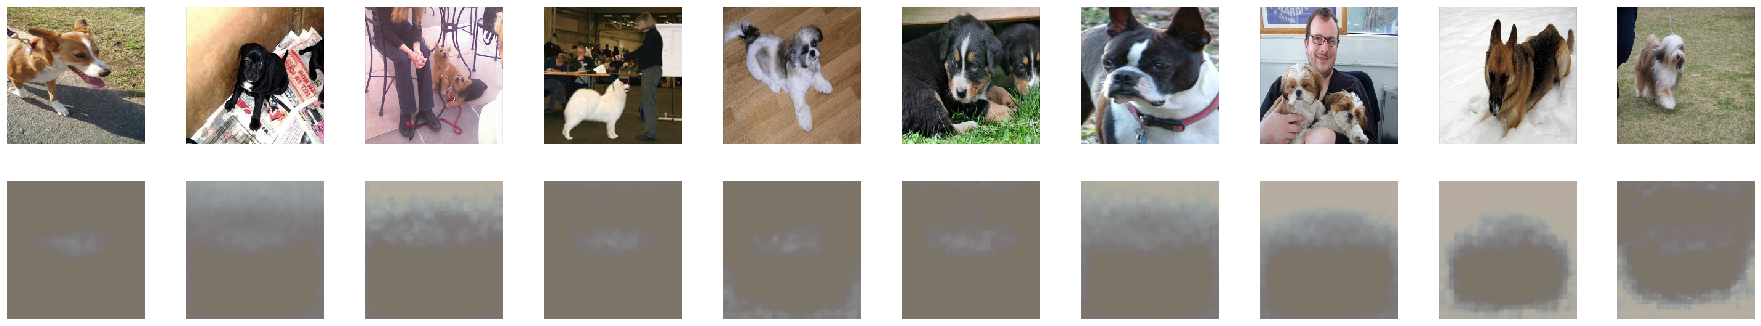

In [19]:
plt.rcParams['figure.figsize'] = [25, 5]

fig, axs = plt.subplots(2, 10)
fig.tight_layout()
axs = axs.ravel()

for i in range(20):
    if i < 10:
        image = data[i][0].transpose_(0,2)
        image = denormalize(image, MEAN, STD, gpu=False).numpy().astype(float)
        axs[i].imshow(image)
        axs[i].axis('off')
    else:
        image = generated_x[i-10].transpose_(0,2)
        image = denormalize(image, MEAN, STD, gpu=False).detach().numpy()
        axs[i].imshow(image)
        axs[i].axis('off')

In [21]:
print(numpy.mean(z_mu.detach().numpy(), 0))
print(numpy.mean(numpy.exp(z_logvar.detach().numpy()), 0))

[ 1.9073487e-07 -3.2004715e-05  1.7970800e-06  2.7377158e-05
  5.7816504e-07]
[0.8079208  0.70382994 0.68912065 0.98388004 0.8277663 ]
